# Predictions using the location informations and the prices.

## Load CSV files

In [1]:
import pandas as pd

# Load the two CSV files into dataframes
merge_df = pd.read_csv('/workspaces/Coworking/src/results/merged_df.csv')

# Display the first few rows to confirm the data is loaded correctly
print(merge_df.head())


                    name Neightboorhood  Population  \
0  Talent Garden Madrid        Delicias       28575   
1        Freeland Cowork        Adelfas       18832   
2           LOOM Huertas         Cortes       10816   
3                EslabOn         Opañel       33883   
4                   Area       Delicias       28575   

  Percentage of population between 16 and 64 years ForeignPopulation  \
0                                            69,3%            13.00%   
1                                           64,6 %             8,6 %   
2                                            76,4%             28,4%   
3                                            68,7%            25.00%   
4                                            69,3%            13.00%   

   Unemployes  Household average net rent  Metro Closest bus stop  Mesa Fija  \
0         962                       45392      6             900m        285   
1         591                       50837      5             150m        150

## Data Processing.

In [2]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 13 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   name                                              5 non-null      object
 1   Neightboorhood                                    5 non-null      object
 2   Population                                        5 non-null      int64 
 3   Percentage of population between 16 and 64 years  5 non-null      object
 4   ForeignPopulation                                 5 non-null      object
 5   Unemployes                                        5 non-null      int64 
 6   Household average net rent                        5 non-null      int64 
 7   Metro                                             5 non-null      int64 
 8   Closest bus stop                                  5 non-null      object
 9   Mesa Fija                           

In [3]:
print(merge_df[['Percentage of population between 16 and 64 years', 'ForeignPopulation']])

  Percentage of population between 16 and 64 years ForeignPopulation
0                                            69,3%            13.00%
1                                           64,6 %             8,6 %
2                                            76,4%             28,4%
3                                            68,7%            25.00%
4                                            69,3%            13.00%


In [4]:
import pandas as pd

# Remove the '%' sign from percentage columns and convert to float
merge_df['Percentage of population between 16 and 64 years'] = merge_df['Percentage of population between 16 and 64 years'].str.replace('%', '').str.replace(',', '.').astype(float) / 100
merge_df['ForeignPopulation'] = merge_df['ForeignPopulation'].str.replace('%', '').str.replace(',', '.').astype(float) / 100

# Convert price columns to numeric values (they are currently likely strings)
merge_df['Mesa Fija'] = pd.to_numeric(merge_df['Mesa Fija'], errors='coerce')
merge_df['Mesa Flexible'] = pd.to_numeric(merge_df['Mesa Flexible'], errors='coerce')
merge_df['Despacho Priado'] = pd.to_numeric(merge_df['Despacho Priado'], errors='coerce')
merge_df['Pases/Bonos (días)'] = pd.to_numeric(merge_df['Pases/Bonos (días)'], errors='coerce')

# Check if there are any other non-numeric columns
print(merge_df.dtypes)

# Clean up the data and inspect
print(merge_df.head())


name                                                 object
Neightboorhood                                       object
Population                                            int64
Percentage of population between 16 and 64 years    float64
ForeignPopulation                                   float64
Unemployes                                            int64
Household average net rent                            int64
Metro                                                 int64
Closest bus stop                                     object
Mesa Fija                                             int64
Mesa Flexible                                         int64
Despacho Priado                                       int64
Pases/Bonos (días)                                    int64
dtype: object
                    name Neightboorhood  Population  \
0  Talent Garden Madrid        Delicias       28575   
1        Freeland Cowork        Adelfas       18832   
2           LOOM Huertas         Cortes  

In [5]:
# Check for missing values
print(merge_df.isnull().sum())

name                                                0
Neightboorhood                                      0
Population                                          0
Percentage of population between 16 and 64 years    0
ForeignPopulation                                   0
Unemployes                                          0
Household average net rent                          0
Metro                                               0
Closest bus stop                                    0
Mesa Fija                                           0
Mesa Flexible                                       0
Despacho Priado                                     0
Pases/Bonos (días)                                  0
dtype: int64


## Encoding Categorical Data (Neighboorhood and Closest Bus Stop)

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Encode 'Neightboorhood' column
merge_df['Neightboorhood'] = label_encoder.fit_transform(merge_df['Neightboorhood'])

# Encode 'Closest bus stop' column
merge_df['Closest bus stop'] = label_encoder.fit_transform(merge_df['Closest bus stop'])

print(merge_df)


                    name  Neightboorhood  Population  \
0  Talent Garden Madrid                2       28575   
1        Freeland Cowork               0       18832   
2           LOOM Huertas               1       10816   
3                EslabOn               3       33883   
4                   Area               2       28575   

   Percentage of population between 16 and 64 years  ForeignPopulation  \
0                                             0.693              0.130   
1                                             0.646              0.086   
2                                             0.764              0.284   
3                                             0.687              0.250   
4                                             0.693              0.130   

   Unemployes  Household average net rent  Metro  Closest bus stop  Mesa Fija  \
0         962                       45392      6                 4        285   
1         591                       50837      5        

In [7]:
# Calculate the unemployment percentage
merge_df['Unemployes Percentage'] = (merge_df['Unemployes'] / merge_df['Population'].replace(0, 1)) * 100

# Remove the raw 'Unemployes' column
merge_df = merge_df.drop(columns=['Unemployes'])

# Now, 'merge_df' has the 'Unemployes Percentage' column instead of 'Unemployes'


In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Select the numerical columns you want to scale
numerical_columns = ['Population', 'Percentage of population between 16 and 64 years', 'ForeignPopulation',
                     'Household average net rent', 'Metro', 'Mesa Fija', 'Mesa Flexible', 'Despacho Priado', 
                     'Pases/Bonos (días)', 'Unemployes Percentage']

# Apply the scaling to these columns
merge_df[numerical_columns] = scaler.fit_transform(merge_df[numerical_columns])

# Check the result
merge_df.head()


,name,Neightboorhood,Population,Percentage of population between 16 and 64 years,ForeignPopulation,Household average net rent,Metro,Closest bus stop,Mesa Fija,Mesa Flexible,Despacho Priado,Pases/Bonos (días),Unemployes Percentage
0,Talent Garden Madrid,2,0.538309,-0.094729,-0.599153,0.428712,0.089803,4,1.116274,0.302454,-0.260243,-0.487718,-0.619583
1,Freeland Cowork,0,-0.643259,-1.331468,-1.172257,1.234878,-0.359211,2,-1.429283,-1.359382,-0.353187,-0.487718,-0.998549
2,LOOM Huertas,1,-1.615387,1.773537,1.406708,-0.368423,1.885856,0,0.927714,1.631923,-0.724962,1.999643,0.514106
3,EslabOn,3,1.182028,-0.252611,0.963855,-1.723878,-0.808224,1,-0.882460,-0.628174,-0.632018,-0.536490,1.723609
4,Area,2,0.538309,-0.094729,-0.599153,0.428712,-0.808224,3,0.267755,0.053179,1.970410,-0.487718,-0.619583


## Visualizations.

### Heatmap

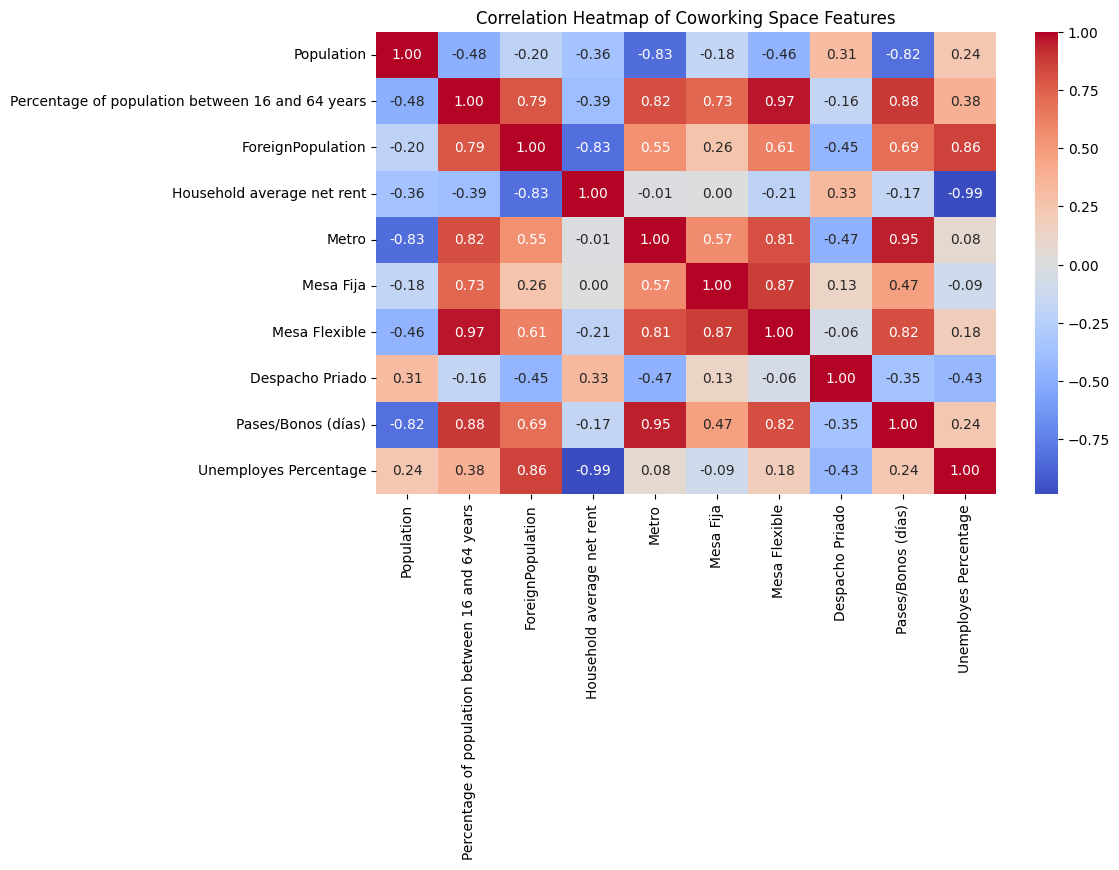

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = merge_df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Coworking Space Features')
plt.show()


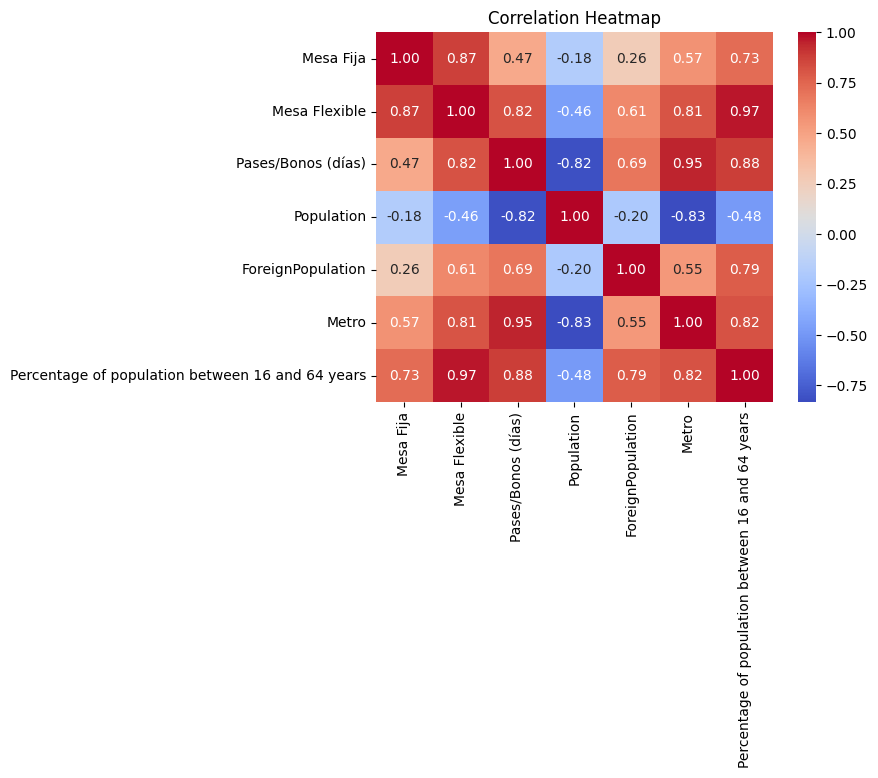

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for relevant columns
correlation_matrix = merge_df[['Mesa Fija', 
                               'Mesa Flexible', 
                               'Pases/Bonos (días)', 
                               'Population', 
                               'ForeignPopulation', 
                               'Metro',  
                               'Percentage of population between 16 and 64 years',
                               ]].corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [11]:
# Remove the "Mesa Fija" column from the dataframe
merge_df = merge_df.drop(columns=['Mesa Fija'])

### 

-Population has a negative correlation with Pases/Bonos (días) (-0.81), suggesting that larger populations might correlate with fewer daily passes, which could be an interesting insight to explore further.

-Percentage of population between 16 and 64 years has a strong positive correlation with Pases/Bonos (días) (0.88), indicating that areas with a higher proportion of working-age individuals may offer more passes.

-ForeignPopulation: This feature shows moderate positive correlations with several others, such as Mesa Flexible (0.61), Pases/Bonos (días) (0.69), and Metro (0.79). It indicates that coworking spaces with higher foreign populations may have a greater number of flexible desks and passes.

-Metro and Pases/Bonos (días): A strong positive correlation of 0.95 suggests that coworking spaces near metro stations tend to have more daily passes, possibly indicating better accessibility for users.

### Scatter Plot

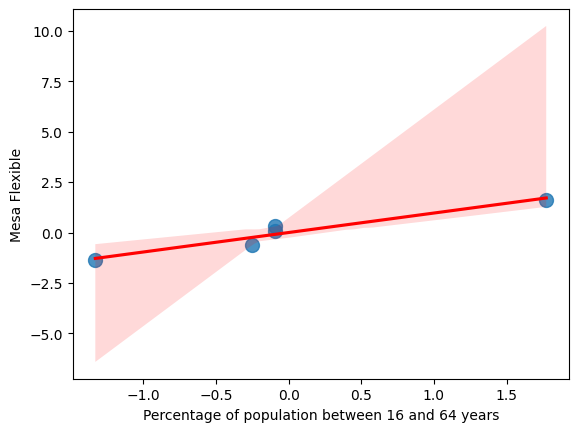

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot with a regression line
sns.regplot(x='Percentage of population between 16 and 64 years', y='Mesa Flexible', data=merge_df, scatter_kws={'s': 100}, line_kws={'color': 'red'})

# Show the plot
plt.show()



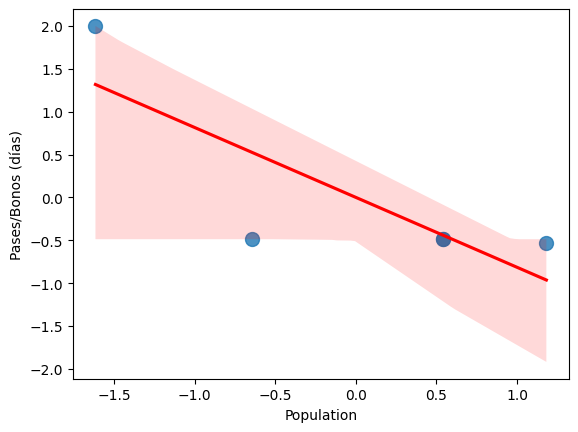

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot with a regression line
sns.regplot(x='Population', y='Pases/Bonos (días)', data=merge_df, scatter_kws={'s': 100}, line_kws={'color': 'red'})

# Show the plot
plt.show()

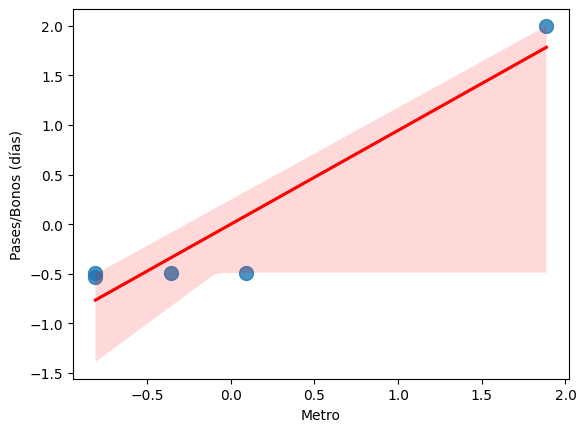

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot with a regression line
sns.regplot(x='Metro', y='Pases/Bonos (días)', data=merge_df, scatter_kws={'s': 100}, line_kws={'color': 'red'})

# Show the plot
plt.show()

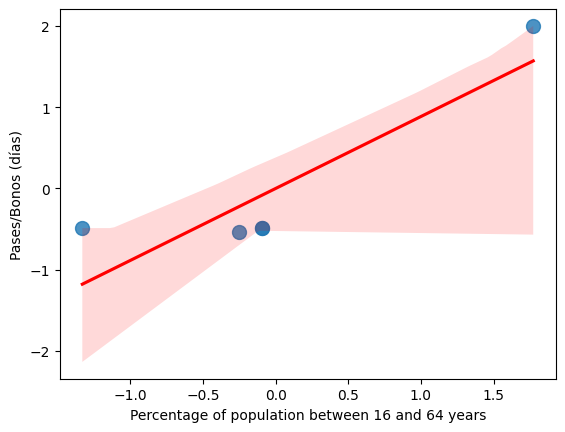

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot with a regression line
sns.regplot(x='Percentage of population between 16 and 64 years', y='Pases/Bonos (días)', data=merge_df, scatter_kws={'s': 100}, line_kws={'color': 'red'})

# Show the plot
plt.show()

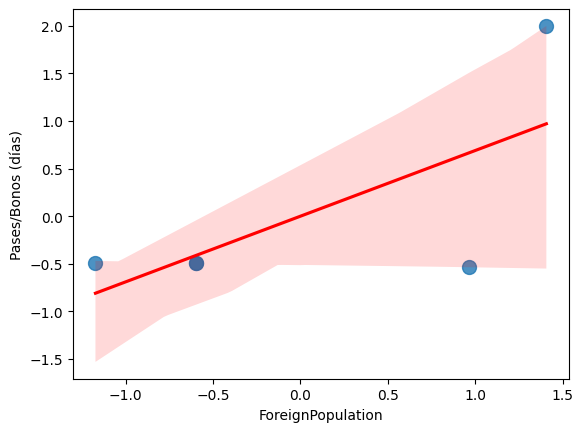

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot with a regression line
sns.regplot(x='ForeignPopulation', y='Pases/Bonos (días)', data=merge_df, scatter_kws={'s': 100}, line_kws={'color': 'red'})

# Show the plot
plt.show()

## Linear Regression Model

### Using the first model using Pases/Bonos (días) as a feature to predict

In [17]:
# Select the relevant numerical columns
numerical_columns = ['Population', 'Percentage of population between 16 and 64 years',
                     'ForeignPopulation', 'Metro',
                     'Mesa Flexible', 'Pases/Bonos (días)'] 

merge_df_numerical = merge_df[numerical_columns]


In [18]:
from sklearn.model_selection import train_test_split

# Split the data for model 1 (Pases/Bonos (días) as target)
X_pases = merge_df_numerical.drop(columns=['Pases/Bonos (días)', 'Mesa Flexible'])
y_pases = merge_df_numerical['Pases/Bonos (días)']

X_train_pases, X_test_pases, y_train_pases, y_test_pases = train_test_split(X_pases, y_pases, test_size=0.2, random_state=42)

# Split the data for model 2 (Mesa Flexible as target)
X_mesa = merge_df_numerical.drop(columns=['Mesa Flexible', 'Pases/Bonos (días)'])
y_mesa = merge_df_numerical['Mesa Flexible']

X_train_mesa, X_test_mesa, y_train_mesa, y_test_mesa = train_test_split(X_mesa, y_mesa, test_size=0.2, random_state=42)


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Model 1: Pases/Bonos (días)
X = merge_df[numerical_columns].drop(columns=['Pases/Bonos (días)'])
y = merge_df['Pases/Bonos (días)']

model_1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_1.fit(X, y)

y_pred_1 = model_1.predict(X)
mse_1 = mean_squared_error(y, y_pred_1)
r2_1 = r2_score(y, y_pred_1)

print(f'Model 1 (Pases/Bonos) MSE: {mse_1}')
print(f'Model 1 (Pases/Bonos) R-squared: {r2_1}')

# Model 2: Mesa Flexible
y2 = merge_df['Mesa Flexible']

model_2 = RandomForestRegressor(n_estimators=100, random_state=42)
model_2.fit(X, y2)

y_pred_2 = model_2.predict(X)
mse_2 = mean_squared_error(y2, y_pred_2)
r2_2 = r2_score(y2, y_pred_2)

print(f'Model 2 (Mesa Flexible) MSE: {mse_2}')
print(f'Model 2 (Mesa Flexible) R-squared: {r2_2}')


Model 1 (Pases/Bonos) MSE: 0.13854524262607107
Model 1 (Pases/Bonos) R-squared: 0.8614547573739288
Model 2 (Mesa Flexible) MSE: 0.14954952830188742
Model 2 (Mesa Flexible) R-squared: 0.8504504716981126


## Feature Importance

In [20]:
# Feature importance for Model 1
importances_1 = model_1.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_1})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Feature importance for Model 2
importances_2 = model_2.feature_importances_
feature_importance_df_2 = pd.DataFrame({'Feature': feature_names, 'Importance': importances_2})
feature_importance_df_2 = feature_importance_df_2.sort_values(by='Importance', ascending=False)
print(feature_importance_df_2)


                                            Feature  Importance
0                                        Population    0.388856
2                                 ForeignPopulation    0.188941
1  Percentage of population between 16 and 64 years    0.144440
4                                     Mesa Flexible    0.144430
3                                             Metro    0.133333
                                            Feature  Importance
0                                        Population    0.266341
4                                     Mesa Flexible    0.230820
1  Percentage of population between 16 and 64 years    0.202144
2                                 ForeignPopulation    0.166092
3                                             Metro    0.134602


In [21]:
import joblib

# Save Model 1
joblib.dump(model_1, 'model_1_pases_bonos.pkl')

# Save Model 2
joblib.dump(model_2, 'model_2_mesa_flexible.pkl')


['model_2_mesa_flexible.pkl']